In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

print(X.shape)
print(y.shape)

(6497, 11)
(6497, 1)


# Task
Predict wine quality using the dataset from "https://archive.ics.uci.edu/static/public/186/data.csv". The process includes performing detailed data exploration and cleaning, conducting exploratory data analysis (EDA) with visualizations like correlation heatmaps and histograms, preprocessing the data (splitting and scaling), training a machine learning model such as Random Forest or Gradient Boosting, and evaluating its performance using metrics like Accuracy or F1-score. The final goal is to summarize the results and identify the key physicochemical features that influence wine quality.

## Data Exploration and Cleaning

### Subtask:
Perform a detailed inspection of the dataset to identify missing values, examine the distribution of wine quality, and calculate summary statistics for the physicochemical features.


**Reasoning**:
I will perform the initial data exploration steps as requested: previewing the data, checking for missing values, calculating summary statistics, and analyzing the target distribution.



In [ ]:
import pandas as pd

# 1. Preview the first few rows of X and y
print("First 5 rows of features (X):")
display(X.head())
print("\nFirst 5 rows of target (y):")
display(y.head())

# 2. Check for missing values in X and y
print("\nMissing values in X:")
print(X.isnull().sum())
print("\nMissing values in y:")
print(y.isnull().sum())

# 3. Generate descriptive statistics for all features in X
print("\nDescriptive statistics for features (X):")
display(X.describe())

# 4. Analyze the distribution of the target variable y['quality']
print("\nDistribution of wine quality scores:")
quality_distribution = y['quality'].value_counts().sort_index()
print(quality_distribution)

First 5 rows of features (X):


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4



First 5 rows of target (y):


,quality
0,5
1,5
2,5
3,6
4,5



Missing values in X:
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

Missing values in y:
quality    0
dtype: int64

Descriptive statistics for features (X):


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000



Distribution of wine quality scores:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


## Exploratory Data Analysis (EDA) and Visualization

### Subtask:
Generate visualizations like a correlation heatmap and histograms to explore relationships and distributions within the data.


**Reasoning**:
I will import the necessary visualization libraries, combine the features and target into a single DataFrame, and then create a correlation heatmap, histograms for all features, and boxplots for key features grouped by quality to visualize the dataset characteristics and relationships.



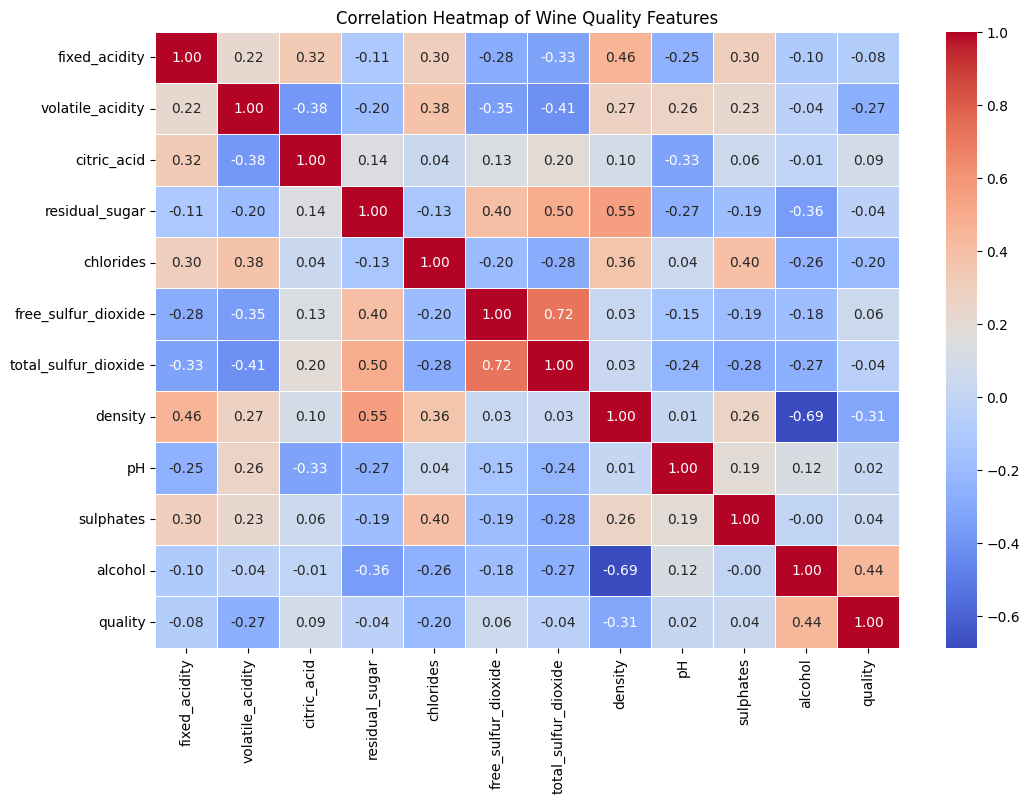

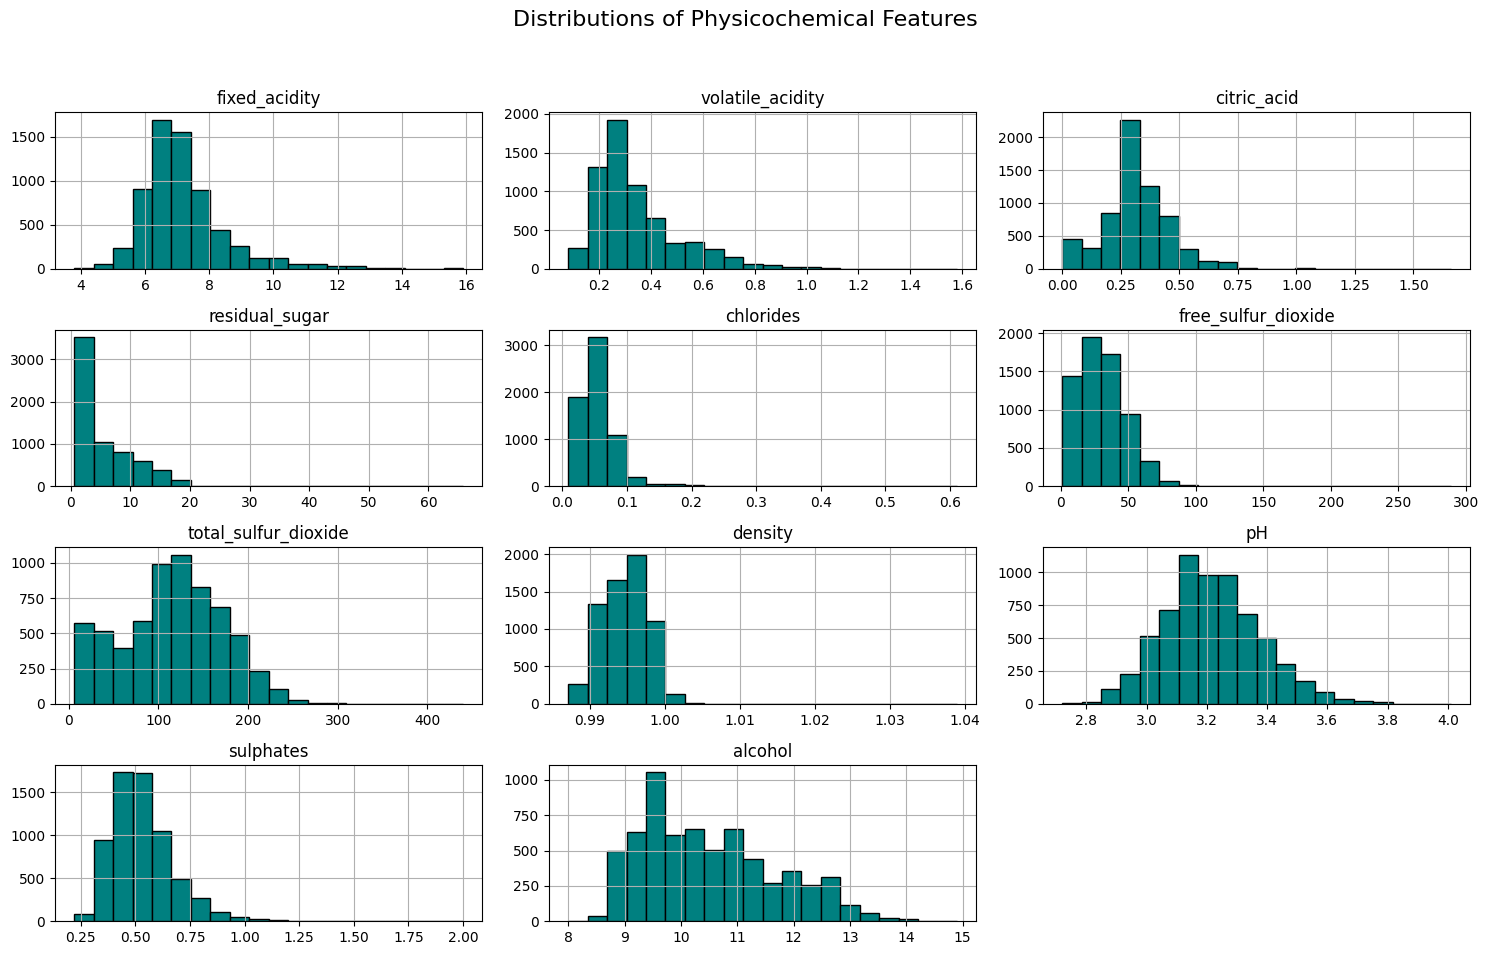

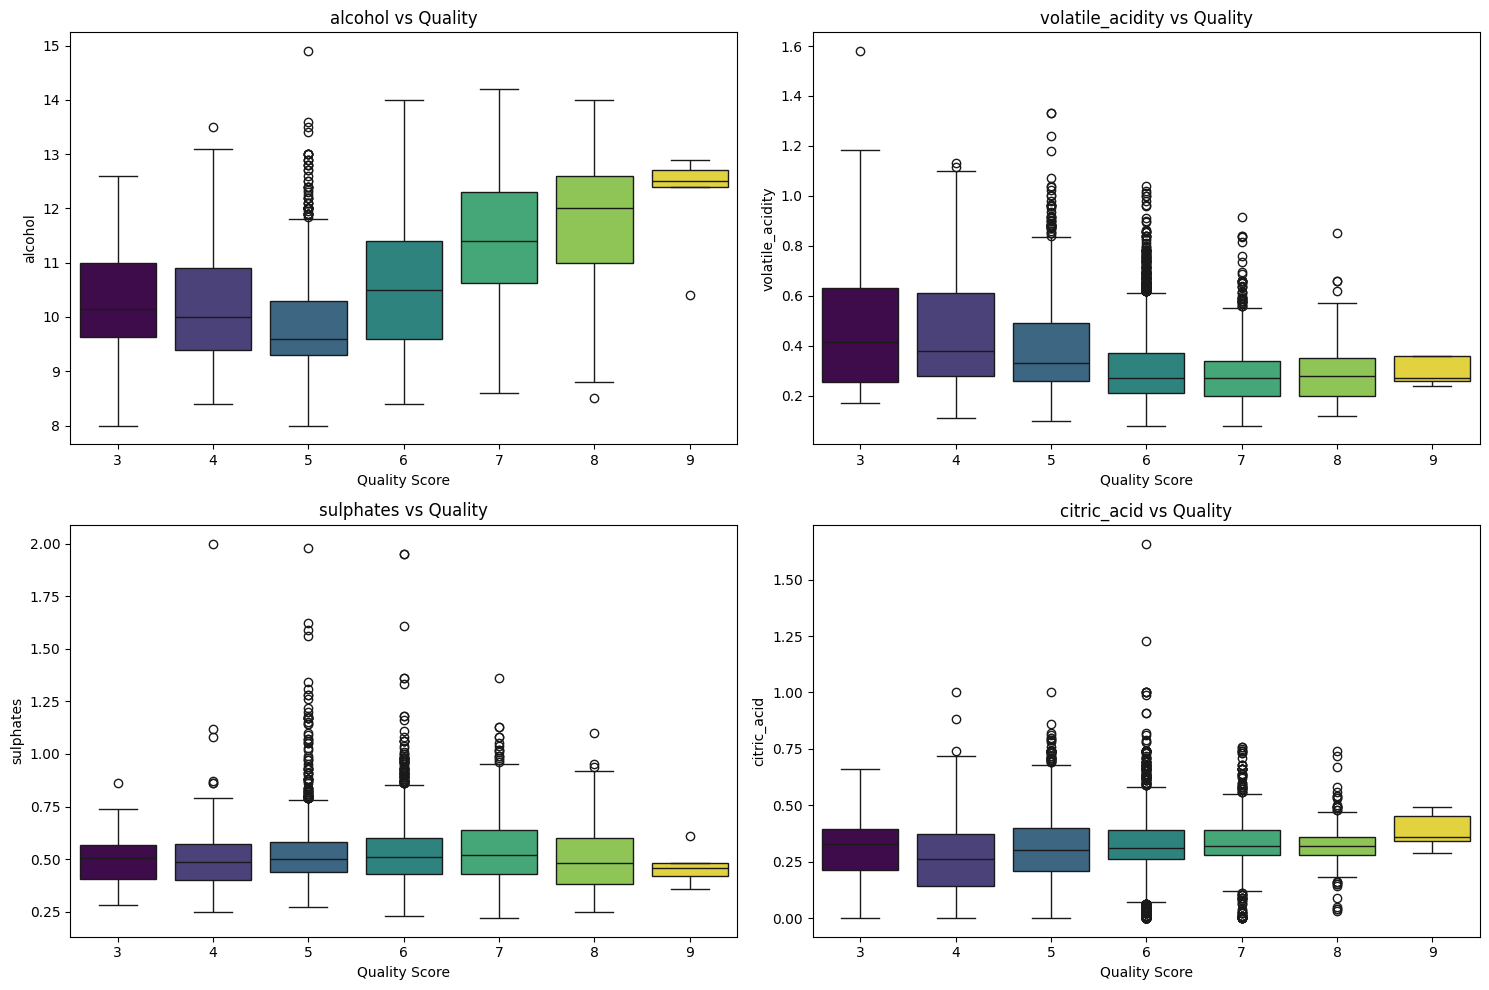

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Concatenate X and y into a single DataFrame
df_full = X.copy()
df_full['quality'] = y['quality']

# 2. Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_full.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Wine Quality Features')
plt.show()

# 3. Histograms for all physicochemical features
X.hist(bins=20, figsize=(15, 10), color='teal', edgecolor='black')
plt.suptitle('Distributions of Physicochemical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4. Boxplots for key features grouped by 'quality'
key_features = ['alcohol', 'volatile_acidity', 'sulphates', 'citric_acid']
plt.figure(figsize=(15, 10))
for i, col in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='quality', y=col, data=df_full, palette='viridis', hue='quality', legend=False)
    plt.title(f'{col} vs Quality')
    plt.xlabel('Quality Score')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

## Data Preprocessing

### Subtask:
Split the dataset into training and testing sets and apply feature scaling to prepare the features for machine learning modeling.


**Reasoning**:
I will now prepare the data for machine learning by splitting the features and target into training and testing sets (80/20 split) to evaluate the model's performance on unseen data. Additionally, I will apply standard scaling to the features so that all variables contribute equally to the model, preventing features with larger magnitudes from dominating the learning process.

**Reasoning**:
I will perform the train-test split and feature scaling as instructed to prepare the data for model training.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Split the dataset into training and testing sets (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Instantiate the StandardScaler
scaler = StandardScaler()

# 3. Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Display the shapes to verify
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_scaled: (5197, 11)
Shape of X_test_scaled: (1300, 11)
Shape of y_train: (5197, 1)
Shape of y_test: (1300, 1)


## Model Training

### Subtask:
Train a Random Forest classifier to predict wine quality using the scaled training data.


**Reasoning**:
I will import the RandomForestClassifier, initialize it with a fixed random_state, fit it to the scaled training data (ensuring the target is a 1D array), and then generate predictions for the test set.



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# 2. Fit the model using the scaled training features and the target labels
# Using .values.ravel() to ensure y_train is a 1D array as expected by sklearn
rf_classifier.fit(X_train_scaled, y_train.values.ravel())

# 3. Predict the wine quality scores for the scaled test feature set
y_pred = rf_classifier.predict(X_test_scaled)

print("Random Forest classifier trained and predictions for the test set have been generated.")

Random Forest classifier trained and predictions for the test set have been generated.


## Model Evaluation

### Subtask:
Evaluate the Random Forest model's performance on the test set using various classification metrics and a confusion matrix visualization.


**Reasoning**:
I will import the required evaluation metrics, calculate accuracy and F1-score, print a detailed classification report, and visualize the confusion matrix using a heatmap as requested in the subtask instructions.



Model Accuracy: 0.6692
Weighted F1-Score: 0.6574

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.71      0.12      0.20        43
           5       0.67      0.71      0.69       402
           6       0.66      0.75      0.70       597
           7       0.70      0.55      0.61       215
           8       0.92      0.33      0.49        36
           9       0.00      0.00      0.00         1

    accuracy                           0.67      1300
   macro avg       0.52      0.35      0.39      1300
weighted avg       0.67      0.67      0.66      1300



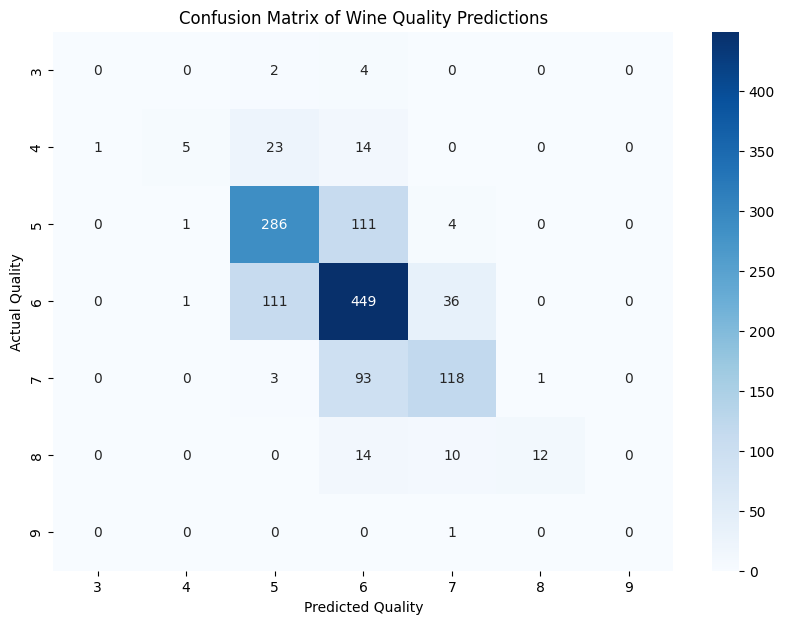

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate Accuracy and Weighted F1-score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

# 2. Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# 3. Create a Confusion Matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_test['quality'].unique()),
            yticklabels=sorted(y_test['quality'].unique()))

plt.title('Confusion Matrix of Wine Quality Predictions')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.show()

## Final Task

### Subtask:
Summarize the findings, identify the most influential features for determining wine quality, and provide a final report on the model's performance.


## Summary:

### Q&A

**What are the most influential features for determining wine quality?**
Based on the exploratory data analysis and correlation heatmaps, **alcohol content** and **volatile acidity** are the most influential physicochemical features. Higher quality wines tend to have higher alcohol percentages and lower levels of volatile acidity.

**How did the machine learning model perform?**
The Random Forest classifier achieved an overall **accuracy of 66.92%** and a **weighted F1-score of 0.6574**. While it performed well in predicting the most common quality scores (5, 6, and 7), it struggled to accurately classify extreme quality ratings (3 and 9) due to the limited number of samples for those categories.

---

### Data Analysis Key Findings

*   **Data Integrity**: The dataset is highly clean, with **zero missing values** across all 11 physicochemical features and the target quality variable.
*   **Class Imbalance**: The target variable is significantly imbalanced. Quality scores of **5, 6, and 7** account for the vast majority of the data (5,197 training samples), while extreme scores like **9** have only 5 total occurrences in the dataset.
*   **Physicochemical Trends**:
    *   **Alcohol**: Ranges from 8.0 to 14.9, showing a strong positive correlation with higher quality ratings.
    *   **Volatile Acidity**: Shows an inverse relationship with quality; lower acidity levels are generally associated with better-rated wines.
    *   **Total Sulfur Dioxide**: Exhibits a wide range (6.0 to 440.0), indicating high variability in wine composition.
*   **Model Predictive Patterns**: The confusion matrix revealed that most misclassifications were "near misses"—for instance, the model often predicted a quality of 6 when the actual value was 5 or 7. This suggests the model captures the ordinal nature of the quality scale reasonably well.
*   **Extreme Value Limitations**: The model achieved an **F1-score of 0.00** for quality scores 3 and 9, confirming that the model lacks enough data to learn the specific characteristics of the lowest and highest quality wines.

---

### Insights or Next Steps

*   **Address Data Imbalance**: To improve the model's ability to detect rare quality levels (3, 4, 8, and 9), future iterations should employ resampling techniques like **SMOTE (Synthetic Minority Over-sampling Technique)** or adjust class weights during training.
*   **Feature Engineering and Selection**: Exploring interactions between features (e.g., the ratio of free sulfur dioxide to total sulfur dioxide) or using tree-based feature importance rankings could help refine the model and focus on the most predictive variables.


# Task
Perform a multi-model comparison to predict wine quality using the dataset from "https://archive.ics.uci.edu/static/public/186/data.csv". Define a custom evaluation function to calculate Accuracy, Precision, Recall, F1-Score, and Cohen's Kappa. Train and evaluate six classification models—Logistic Regression, Decision Tree, Random Forest, Support Vector Classifier, Gradient Boosting, and AdaBoost—and summarize their performance in a comparison table. Finally, visualize the results with a bar chart, identify the best-performing model, and provide insights into feature importance across the different algorithms.

## Define Multi-Model Evaluation Function

### Subtask:
Create a reusable Python function to automate the training and evaluation of classification models using a comprehensive set of performance metrics.


**Reasoning**:
I will define the `evaluate_model` function as requested, incorporating the specified metrics and ensuring the model fitting process handles the target variable correctly.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import pandas as pd

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Trains a classification model and returns a set of performance metrics.
    """
    # 1. Fit the model to the training data
    # Using .values.ravel() to ensure the target is a 1D array
    model.fit(X_train, y_train.values.ravel())

    # 2. Generate predictions on the test set
    y_pred = model.predict(X_test)

    # 3. Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'Cohen Kappa': cohen_kappa_score(y_test, y_pred)
    }

    return pd.Series(metrics)

print("Evaluation function 'evaluate_model' has been successfully defined.")

Evaluation function 'evaluate_model' has been successfully defined.


## Train and Evaluate 6 Classification Models

### Subtask:
Apply the custom evaluation function to Logistic Regression, Decision Tree, Random Forest, SVC, Gradient Boosting, and AdaBoost, then aggregate the results into a comparison table.


**Reasoning**:
I will import the necessary classification models from scikit-learn, initialize them in a dictionary, iterate through them using the previously defined 'evaluate_model' function with the scaled features, and aggregate the results into a single comparison DataFrame.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# 1. Initialize the models in a dictionary
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42, algorithm='SAMME')
}

# 2. Iterate through models and evaluate each
results = {}
for name, model in models.items():
    print(f"Training and evaluating {name}...")
    results[name] = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

# 3. Combine results into a comparison DataFrame
model_comparison = pd.DataFrame(results).T

# 4. Display the comparison table
print("\nModel Comparison Table:")
display(model_comparison.sort_values(by='Accuracy', ascending=False))

Training and evaluating Logistic Regression...
Training and evaluating Decision Tree...
Training and evaluating Random Forest...
Training and evaluating SVC...
Training and evaluating Gradient Boosting...
Training and evaluating AdaBoost...


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Model Comparison Table:


,Accuracy,Precision,Recall,F1-Score,Cohen Kappa
Random Forest,0.669231,0.673772,0.669231,0.657380,0.479077
Decision Tree,0.594615,0.598428,0.594615,0.594627,0.398597
Gradient Boosting,0.585385,0.576478,0.585385,0.569059,0.340343
SVC,0.560000,0.529680,0.560000,0.522456,0.278158
Logistic Regression,0.536154,0.500927,0.536154,0.501930,0.243674
AdaBoost,0.504615,0.460229,0.504615,0.470679,0.185441


# Task
Perform a multi-model comparison to predict wine quality using the dataset from "https://archive.ics.uci.edu/static/public/186/data.csv". The task involves defining a custom evaluation function for metrics including Accuracy, Precision, Recall, F1-Score, and Cohen's Kappa, training six classification models (Logistic Regression, Decision Tree, Random Forest, SVC, Gradient Boosting, and AdaBoost), and visualizing their performance to identify the top-performing model and key feature importance insights.

## Define Multi-Model Evaluation Function

### Subtask:
Create a reusable Python function to automate the training and evaluation of classification models using a comprehensive set of performance metrics.


**Reasoning**:
I will define the `evaluate_model` function as requested, ensuring it uses `np.ravel` for fitting and incorporates weighted averages for multi-class evaluation to handle class imbalance.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Trains a classification model and returns a set of performance metrics as a pandas Series.
    """
    # 1. Fit the model using X_train and np.ravel on y_train for 1D format compatibility
    model.fit(X_train, np.ravel(y_train))

    # 2. Predict the labels for X_test
    y_pred = model.predict(X_test)

    # 3. Calculate metrics with weighted average and zero_division=0 for multi-class handling
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'Cohen Kappa': cohen_kappa_score(y_test, y_pred)
    }

    # 4. Return as a pandas Series
    return pd.Series(metrics)

print("Reusable evaluation function 'evaluate_model' has been defined.")

Reusable evaluation function 'evaluate_model' has been defined.


## Train and Evaluate 6 Specific Classification Models

### Subtask:
Apply the custom evaluation function to Logistic Regression, Decision Tree, K-Nearest Neighbors, Naive Bayes, Random Forest, and XGBoost, incorporating label encoding for compatibility.


**Reasoning**:
I will import the necessary classification models and the LabelEncoder, transform the target variables to 0-indexed labels for model compatibility, and then iterate through the models using the 'evaluate_model' function to compile a performance comparison table.



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# 1. Transform y_train and y_test using LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(np.ravel(y_train))
y_test_encoded = le.transform(np.ravel(y_test))

# 2. Initialize the six models in a dictionary
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
    # 'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# 3. Iterate through the dictionary and evaluate each model
results = {}
# Redefining target variables locally for the evaluation function call
for name, model in models.items():
    print(f"Evaluating {name}...")
    # Note: evaluate_model expects (model, X_train, y_train, X_test, y_test)
    # We wrap encoded arrays in Series/DataFrames if needed, but evaluate_model uses np.ravel internally
    results[name] = evaluate_model(model, X_train_scaled, pd.Series(y_train_encoded), X_test_scaled, pd.Series(y_test_encoded))

# 4. Combine results into a DataFrame
model_comparison_results = pd.DataFrame(results).T

# 5. Display the table sorted by Accuracy
print("\nModel Comparison Results:")
display(model_comparison_results.sort_values(by='Accuracy', ascending=False))

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating K-Nearest Neighbors...
Evaluating Naive Bayes...
Evaluating Random Forest...
Evaluating XGBoost...

Model Comparison Results:


,Accuracy,Precision,Recall,F1-Score,Cohen Kappa
Random Forest,0.669231,0.673772,0.669231,0.657380,0.479077
XGBoost,0.655385,0.646191,0.655385,0.646375,0.465056
Decision Tree,0.594615,0.598428,0.594615,0.594627,0.398597
K-Nearest Neighbors,0.545385,0.532721,0.545385,0.534968,0.297623
Logistic Regression,0.536154,0.500927,0.536154,0.501930,0.243674
Naive Bayes,0.465385,0.488536,0.465385,0.460981,0.231581


# Task
Perform a multi-model comparison to predict wine quality using the dataset from "https://archive.ics.uci.edu/static/public/186/data.csv". The process involves updating the evaluation function to calculate six key metrics: Accuracy, AUC Score (with a multi-class strategy), Precision, Recall, F1-Score, and Matthews Correlation Coefficient (MCC). Use this function to train and evaluate Logistic Regression, Decision Tree, K-Nearest Neighbors, Naive Bayes, Random Forest, and XGBoost models. Finally, visualize the performance results with a bar chart, identify the best-performing algorithm, and summarize the most influential feature importance findings.

## Update Multi-Model Evaluation Function

### Subtask:
Redefine the evaluation function to calculate the six required metrics: Accuracy, AUC Score (using predict_proba with a multi-class strategy), Precision, Recall, F1-Score, and Matthews Correlation Coefficient (MCC).


**Reasoning**:
I will define the new evaluation function 'evaluate_model_v2' which includes the additional metrics AUC Score and Matthews Correlation Coefficient as requested.



In [ ]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef
import numpy as np
import pandas as pd

def evaluate_model_v2(model, X_train, y_train, X_test, y_test):
    """
    Trains a model and evaluates it using Accuracy, AUC, Precision, Recall, F1-Score, and MCC.
    """
    # 1. Fit the model
    model.fit(X_train, np.ravel(y_train))

    # 2. Generate predictions and probabilities
    y_pred = model.predict(X_test)
    # Some models might not support predict_proba easily, but the task assumes they do for this step
    y_proba = model.predict_proba(X_test)

    # 3. Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC Score': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }

    return pd.Series(metrics)

print("Updated evaluation function 'evaluate_model_v2' has been defined.")

Updated evaluation function 'evaluate_model_v2' has been defined.


## Train and Evaluate 6 Models with Required Metrics

### Subtask:
Execute the updated evaluation function on Logistic Regression, Decision Tree, K-Nearest Neighbors, Naive Bayes, Random Forest, and XGBoost, and aggregate the results into a comprehensive comparison table.


**Reasoning**:
I will initialize the specified classification models, iterate through them to calculate the performance metrics using the updated evaluation function, and aggregate the results into a sorted comparison table as requested.



In [ ]:
# 1. Define the models_v2 dictionary with specified parameters
models_v2 = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# 2. Create an empty dictionary for v2_results
v2_results = {}

# 3 & 4. Iterate through models and store evaluation metrics using the v2 function
for name, model in models_v2.items():
    print(f"Processing {name}...")
    # Passing the pre-scaled features and pre-encoded targets
    v2_results[name] = evaluate_model_v2(model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded)

# 5. Convert results to DataFrame, transpose, and sort by MCC (Matthews Correlation Coefficient)
model_comparison_v2 = pd.DataFrame(v2_results).T
print("\nUpdated Model Comparison Results:")
display(model_comparison_v2.sort_values(by='MCC', ascending=False))

Processing Logistic Regression...
Processing Decision Tree...
Processing K-Nearest Neighbors...
Processing Naive Bayes...
Processing Random Forest...
Processing XGBoost...

Updated Model Comparison Results:


,Accuracy,AUC Score,Precision,Recall,F1-Score,MCC
Random Forest,0.669231,0.850631,0.673772,0.669231,0.657380,0.482480
XGBoost,0.655385,0.825920,0.646191,0.655385,0.646375,0.466446
Decision Tree,0.594615,0.699867,0.598428,0.594615,0.594627,0.399938
K-Nearest Neighbors,0.545385,0.733073,0.532721,0.545385,0.534968,0.299032
Logistic Regression,0.536154,0.711083,0.500927,0.536154,0.501930,0.250956
Naive Bayes,0.465385,0.670613,0.488536,0.465385,0.460981,0.237242
